<a href="https://colab.research.google.com/github/saichandrapandraju/TF-Developer/blob/main/4.%20Seq%20%2B%20Time%20series/2.%20create_series_data_%2B_Train_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [39]:
from tqdm.notebook import tqdm

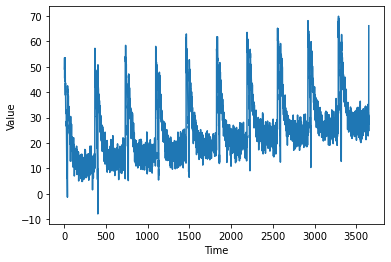

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

create features and labels for model

In [18]:
ds = tf.data.Dataset.range(10)
for item in ds:
  print(item, item.numpy())

tf.Tensor(0, shape=(), dtype=int64) 0
tf.Tensor(1, shape=(), dtype=int64) 1
tf.Tensor(2, shape=(), dtype=int64) 2
tf.Tensor(3, shape=(), dtype=int64) 3
tf.Tensor(4, shape=(), dtype=int64) 4
tf.Tensor(5, shape=(), dtype=int64) 5
tf.Tensor(6, shape=(), dtype=int64) 6
tf.Tensor(7, shape=(), dtype=int64) 7
tf.Tensor(8, shape=(), dtype=int64) 8
tf.Tensor(9, shape=(), dtype=int64) 9


In [19]:
win_ds = ds.window(5, shift=1)  ## creating a window of 5 (actually 4 as we'll see below)
for item in win_ds:
  for sample in item:
    print(sample.numpy(), end=' ')
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [20]:
win_ds = ds.window(5, shift=1, drop_remainder=True) ## dropping remaining values
for item in win_ds:
  for sample in item:
    print(sample.numpy(), end=' ')
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [21]:
flat_ds = win_ds.flat_map(lambda window: window.batch(5)) ## flattening to form a list
for window in flat_ds:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [22]:
xs_ys = flat_ds.map(lambda window: (window[:-1], window[-1:])) ## creating features and labels
for x,y in xs_ys:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [27]:
%%time
xs_ys = flat_ds.map(lambda window: (window[:-1], window[-1:]))  ## shuffling to remove sequence bias
xs_ys = xs_ys.shuffle(buffer_size=10)
for x,y in xs_ys:
  print(x.numpy(), y.numpy())

[5 6 7 8] [9]
[4 5 6 7] [8]
[2 3 4 5] [6]
[0 1 2 3] [4]
[1 2 3 4] [5]
[3 4 5 6] [7]
CPU times: user 48.1 ms, sys: 1.09 ms, total: 49.2 ms
Wall time: 46.4 ms


In [26]:
%%time
xs_ys = flat_ds.map(lambda window: (window[:-1], window[-1:]))
xs_ys = xs_ys.shuffle(buffer_size=10)
xs_ys = xs_ys.batch(2).prefetch(1)  ## creating batches and prefetching for efficient loading
for x,y in xs_ys:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[2 3 4 5]
 [3 4 5 6]]
y =  [[6]
 [7]]
x =  [[4 5 6 7]
 [5 6 7 8]]
y =  [[8]
 [9]]
x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [[4]
 [5]]
CPU times: user 37.5 ms, sys: 2.04 ms, total: 39.5 ms
Wall time: 40.2 ms


In [28]:
## putting everything together
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())


x =  [[2 3 4 5]
 [5 6 7 8]]
y =  [[6]
 [9]]
x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [[4]
 [5]]
x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]


applying above stuff to prev time series data

In [29]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

build and train model

In [34]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

for i in dataset:
  print(i[0].shape, i[1].shape)
  break

(32, 20) (32,)


In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(8, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=2)

Epoch 1/100
94/94 - 1s - loss: 96.7658
Epoch 2/100
94/94 - 0s - loss: 65.3267
Epoch 3/100
94/94 - 0s - loss: 52.6150
Epoch 4/100
94/94 - 0s - loss: 45.4698
Epoch 5/100
94/94 - 0s - loss: 40.6942
Epoch 6/100
94/94 - 0s - loss: 37.2717
Epoch 7/100
94/94 - 0s - loss: 34.8000
Epoch 8/100
94/94 - 0s - loss: 33.1549
Epoch 9/100
94/94 - 0s - loss: 31.8777
Epoch 10/100
94/94 - 0s - loss: 31.0474
Epoch 11/100
94/94 - 0s - loss: 30.1475
Epoch 12/100
94/94 - 0s - loss: 29.5893
Epoch 13/100
94/94 - 0s - loss: 29.0433
Epoch 14/100
94/94 - 0s - loss: 28.7185
Epoch 15/100
94/94 - 0s - loss: 28.2857
Epoch 16/100
94/94 - 0s - loss: 28.0193
Epoch 17/100
94/94 - 0s - loss: 27.7278
Epoch 18/100
94/94 - 0s - loss: 27.4955
Epoch 19/100
94/94 - 0s - loss: 27.3471
Epoch 20/100
94/94 - 0s - loss: 27.1726
Epoch 21/100
94/94 - 0s - loss: 26.9383
Epoch 22/100
94/94 - 0s - loss: 26.7808
Epoch 23/100
94/94 - 0s - loss: 26.6994
Epoch 24/100
94/94 - 0s - loss: 26.4194
Epoch 25/100
94/94 - 0s - loss: 26.3773
Epoch 26/

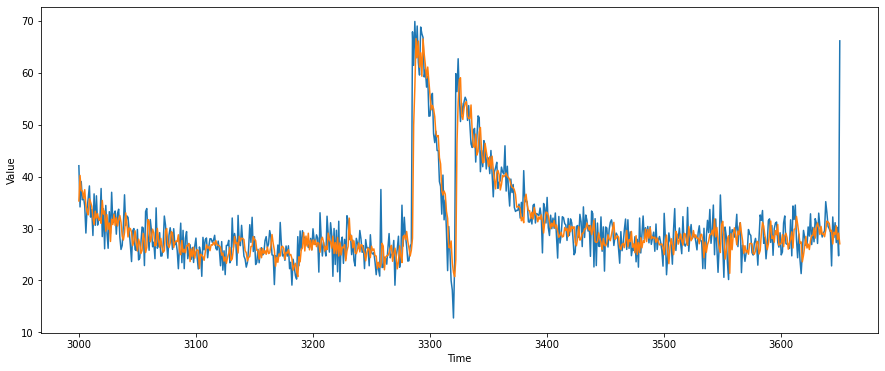

In [40]:
forecast = []
for time in tqdm(range(len(series) - window_size)):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(15, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.0313096

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[window_size]),
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=2)

Epoch 1/100
94/94 - 1s - loss: 73.6940
Epoch 2/100
94/94 - 0s - loss: 34.6982
Epoch 3/100
94/94 - 0s - loss: 31.6886
Epoch 4/100
94/94 - 0s - loss: 29.8161
Epoch 5/100
94/94 - 0s - loss: 28.7102
Epoch 6/100
94/94 - 0s - loss: 27.9126
Epoch 7/100
94/94 - 0s - loss: 27.3130
Epoch 8/100
94/94 - 0s - loss: 26.8230
Epoch 9/100
94/94 - 0s - loss: 26.2054
Epoch 10/100
94/94 - 0s - loss: 25.9049
Epoch 11/100
94/94 - 0s - loss: 25.5417
Epoch 12/100
94/94 - 0s - loss: 25.3623
Epoch 13/100
94/94 - 0s - loss: 25.2019
Epoch 14/100
94/94 - 0s - loss: 24.9074
Epoch 15/100
94/94 - 0s - loss: 24.5923
Epoch 16/100
94/94 - 0s - loss: 24.5104
Epoch 17/100
94/94 - 0s - loss: 24.4169
Epoch 18/100
94/94 - 0s - loss: 24.2405
Epoch 19/100
94/94 - 0s - loss: 24.1358
Epoch 20/100
94/94 - 0s - loss: 24.0716
Epoch 21/100
94/94 - 1s - loss: 23.9100
Epoch 22/100
94/94 - 0s - loss: 23.8439
Epoch 23/100
94/94 - 0s - loss: 23.8265
Epoch 24/100
94/94 - 0s - loss: 23.5994
Epoch 25/100
94/94 - 0s - loss: 23.6037
Epoch 26/

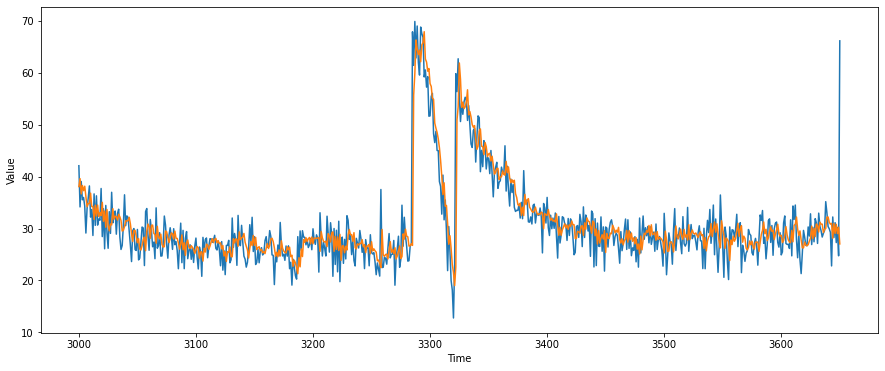

In [43]:
forecast = []
for time in tqdm(range(len(series) - window_size)):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(15, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [44]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.025513

fine but not great. Next we'll choose good LR with dynamically changing it and also apply RNN's as we're dealing with sequences ;->